# SVM Modifications: Pre-processing using different methods + SVM classifier
Dataset used: IY011 - 2-fold difference in parameter spaces

In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from dataloaders import load_loader_from_disk
import pycatch22

In [2]:
# ==========================================
# CONFIGURATION
# ==========================================
# 2-fold change experiments (from IY011)
EXPERIMENTS = [
    {
        "name": "1. Baseline (Sobol)",
        "data_dir": "../EXP-25-IY011/data",
        "csv_name": "IY011_simulation_parameters_sobol.csv",
        "train_save_path":"IY011_static_train.pt",
        "val_save_path":"IY011_static_val.pt",
        "test_save_path":"IY011_static_test.pt",
        "color": "black"
    },
    {
        "name": "2. Mu Variation",
        "data_dir": "../EXP-25-IY011/data_mu_variation",
        "csv_name": "IY011_simulation_mu_parameters_sobol.csv",
        "train_save_path":"IY011_static_train.pt",
        "val_save_path":"IY011_static_val.pt",
        "test_save_path":"IY011_static_test.pt",
        "color": "blue"
    },
    {
        "name": "3. CV Variation",
        "data_dir": "../EXP-25-IY011/data_cv_variation",
        "csv_name": "IY011_simulation_cv_parameters_sobol.csv",
        "train_save_path":"IY011_static_train.pt",
        "val_save_path":"IY011_static_val.pt",
        "test_save_path":"IY011_static_test.pt",
        "color": "green"
    },
    {
        "name": "4. Tac Variation",
        "data_dir": "../EXP-25-IY011/data_t_ac_variation",
        "csv_name": "IY011_simulation_t_ac_parameters_sobol.csv",
        "train_save_path":"IY011_static_train.pt",
        "val_save_path":"IY011_static_val.pt",
        "test_save_path":"IY011_static_test.pt",
        "color": "red"
    }
]

# ==========================================
BASELINE_DATA_ROOT = Path(EXPERIMENTS[0]["data_dir"])
MU_DATA_ROOT = Path(EXPERIMENTS[1]["data_dir"])
CV_DATA_ROOT = Path(EXPERIMENTS[2]["data_dir"]) 
TAC_DATA_ROOT = Path(EXPERIMENTS[3]["data_dir"])

baseline_train_save_path = BASELINE_DATA_ROOT / EXPERIMENTS[0]["train_save_path"]
baseline_val_save_path   = BASELINE_DATA_ROOT / EXPERIMENTS[0]["val_save_path"]
baseline_test_save_path  = BASELINE_DATA_ROOT / EXPERIMENTS[0]["test_save_path"]
baseline_train_loader = load_loader_from_disk(baseline_train_save_path)
baseline_val_loader = load_loader_from_disk(baseline_val_save_path)
baseline_test_loader = load_loader_from_disk(baseline_test_save_path)

cv_train_save_path = CV_DATA_ROOT / EXPERIMENTS[2]["train_save_path"]
cv_val_save_path   = CV_DATA_ROOT / EXPERIMENTS[2]["val_save_path"]
cv_test_save_path  = CV_DATA_ROOT / EXPERIMENTS[2]["test_save_path"]
cv_train_loader = load_loader_from_disk(cv_train_save_path)
cv_val_loader = load_loader_from_disk(cv_val_save_path)
cv_test_loader = load_loader_from_disk(cv_test_save_path)   

tac_train_save_path = TAC_DATA_ROOT / EXPERIMENTS[3]["train_save_path"]
tac_val_save_path   = TAC_DATA_ROOT / EXPERIMENTS[3]["val_save_path"]
tac_test_save_path  = TAC_DATA_ROOT / EXPERIMENTS[3]["test_save_path"]
tac_train_loader = load_loader_from_disk(tac_train_save_path)
tac_val_loader = load_loader_from_disk(tac_val_save_path)
tac_test_loader = load_loader_from_disk(tac_test_save_path)

mu_train_save_path = MU_DATA_ROOT / EXPERIMENTS[1]["train_save_path"]
mu_val_save_path   = MU_DATA_ROOT / EXPERIMENTS[1]["val_save_path"]
mu_test_save_path  = MU_DATA_ROOT / EXPERIMENTS[1]["test_save_path"]
mu_train_loader = load_loader_from_disk(mu_train_save_path)
mu_val_loader = load_loader_from_disk(mu_val_save_path)
mu_test_loader = load_loader_from_disk(mu_test_save_path)   

📂 Loading static data from ../EXP-25-IY011/data/IY011_static_train.pt...
📂 Loading static data from ../EXP-25-IY011/data/IY011_static_val.pt...
📂 Loading static data from ../EXP-25-IY011/data/IY011_static_test.pt...
📂 Loading static data from ../EXP-25-IY011/data_cv_variation/IY011_static_train.pt...
📂 Loading static data from ../EXP-25-IY011/data_cv_variation/IY011_static_val.pt...
📂 Loading static data from ../EXP-25-IY011/data_cv_variation/IY011_static_test.pt...
📂 Loading static data from ../EXP-25-IY011/data_t_ac_variation/IY011_static_train.pt...
📂 Loading static data from ../EXP-25-IY011/data_t_ac_variation/IY011_static_val.pt...
📂 Loading static data from ../EXP-25-IY011/data_t_ac_variation/IY011_static_test.pt...
📂 Loading static data from ../EXP-25-IY011/data_mu_variation/IY011_static_train.pt...
📂 Loading static data from ../EXP-25-IY011/data_mu_variation/IY011_static_val.pt...
📂 Loading static data from ../EXP-25-IY011/data_mu_variation/IY011_static_test.pt...


In [4]:
import numpy as np
from tqdm import tqdm
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

def extract_catch22_from_loader(loader, exp_name):
    """
    Iterates through a DataLoader and extracts 22 canonical features per sample.
    Returns: DataFrame (N, 22), Labels (N,)
    """
    features_list = []
    y_list = []
    
    # We iterate manually to keep it simple and safe
    # Catch22 is fast enough that we don't need complex multiprocessing
    print(f"   Extracting Catch22 features for {exp_name}...")
    
    for X_batch, y_batch in tqdm(loader, leave=False):
        X_numpy = X_batch.numpy().squeeze() # (Batch, Time)
        y_numpy = y_batch.numpy().flatten()
        
        for i in range(X_numpy.shape[0]):
            time_series = X_numpy[i, :]
            
            # Catch22 returns a dictionary: {'names': [...], 'values': [...]}
            # We convert it to a simple dict for DataFrame creation
            c22_out = pycatch22.catch22_all(time_series)
            
            # Map names to values
            feat_dict = dict(zip(c22_out['names'], c22_out['values']))
            features_list.append(feat_dict)
            y_list.append(y_numpy[i])
            
    # Convert to DataFrame
    df_features = pd.DataFrame(features_list)
    y_labels = np.array(y_list)
    
    return df_features, y_labels

def run_catch22_classifier_showdown(train_loader, test_loader, exp_name="Experiment"):
    print(f"\n=== Catch22 Classifier Showdown: {exp_name} ===")
    
    # 1. Reuse your existing extraction logic
    # (Assuming extract_catch22_from_loader is defined from previous step)
    X_train, y_train = extract_catch22_from_loader(train_loader, f"{exp_name} (Train)")
    X_test, y_test   = extract_catch22_from_loader(test_loader, f"{exp_name} (Test)")
    
    if len(X_train) == 0: return

    # --- CONTENDER 1: SVM (The Current Winner) ---
    pipe_svm = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='rbf', C=1.0, gamma='scale'))
    ])
    pipe_svm.fit(X_train, y_train)
    acc_svm = accuracy_score(y_test, pipe_svm.predict(X_test))
    print(f"🔹 SVM Accuracy:      {acc_svm:.2%}")

    # --- CONTENDER 2: MLP (Your Suggestion) ---
    # A simple 2-layer network. Standard Scaler is CRITICAL for MLPs.
    pipe_mlp = Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', MLPClassifier(hidden_layer_sizes=(64, 32), 
                              activation='relu', 
                              max_iter=1000, 
                              random_state=42))
    ])
    pipe_mlp.fit(X_train, y_train)
    acc_mlp = accuracy_score(y_test, pipe_mlp.predict(X_test))
    print(f"🔹 MLP Accuracy:      {acc_mlp:.2%}")

    # --- CONTENDER 3: XGBoost (The Tabular King) ---
    # XGBoost usually doesn't need scaling, but it doesn't hurt.
    model_xgb = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
    model_xgb.fit(X_train, y_train)
    acc_xgb = accuracy_score(y_test, model_xgb.predict(X_test))
    print(f"🔹 XGBoost Accuracy:  {acc_xgb:.2%}")
    
    # Return winner
    best_acc = max(acc_svm, acc_mlp, acc_xgb)
    print(f"🏆 Winner for {exp_name}: {best_acc:.2%}")
    print("-" * 30)
    return acc_svm, acc_mlp, acc_xgb

# ==========================================
# EXECUTE SHOWDOWN
# ==========================================

# Run on the hard datasets
baseline_acc_svm, baseline_acc_mlp, baseline_acc_xgb = run_catch22_classifier_showdown(baseline_train_loader, baseline_test_loader, "Baseline")
mu_acc_svm, mu_acc_mlp, mu_acc_xgb = run_catch22_classifier_showdown(mu_train_loader, mu_test_loader, "Mu Variation")
cv_acc_svm, cv_acc_mlp, cv_acc_xgb = run_catch22_classifier_showdown(cv_train_loader, cv_test_loader, "CV Variation")
tac_acc_svm, tac_acc_mlp, tac_acc_xgb = run_catch22_classifier_showdown(tac_train_loader, tac_test_loader, "Tac Variation")


=== Catch22 Classifier Showdown: Baseline ===
   Extracting Catch22 features for Baseline (Train)...


   Extracting Catch22 features for Baseline (Test)...


🔹 SVM Accuracy:      88.17%
🔹 MLP Accuracy:      85.67%


/home/ianyang/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:50:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔹 XGBoost Accuracy:  87.17%
🏆 Winner for Baseline: 88.17%
------------------------------

=== Catch22 Classifier Showdown: Mu Variation ===
   Extracting Catch22 features for Mu Variation (Train)...


   Extracting Catch22 features for Mu Variation (Test)...


🔹 SVM Accuracy:      92.17%


/home/ianyang/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:52:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔹 MLP Accuracy:      94.50%
🔹 XGBoost Accuracy:  92.83%
🏆 Winner for Mu Variation: 94.50%
------------------------------

=== Catch22 Classifier Showdown: CV Variation ===
   Extracting Catch22 features for CV Variation (Train)...


   Extracting Catch22 features for CV Variation (Test)...


🔹 SVM Accuracy:      95.17%


/home/ianyang/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:55:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔹 MLP Accuracy:      95.17%
🔹 XGBoost Accuracy:  98.00%
🏆 Winner for CV Variation: 98.00%
------------------------------

=== Catch22 Classifier Showdown: Tac Variation ===
   Extracting Catch22 features for Tac Variation (Train)...


   Extracting Catch22 features for Tac Variation (Test)...


🔹 SVM Accuracy:      81.83%
🔹 MLP Accuracy:      83.00%
🔹 XGBoost Accuracy:  84.33%
🏆 Winner for Tac Variation: 84.33%
------------------------------


/home/ianyang/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:56:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


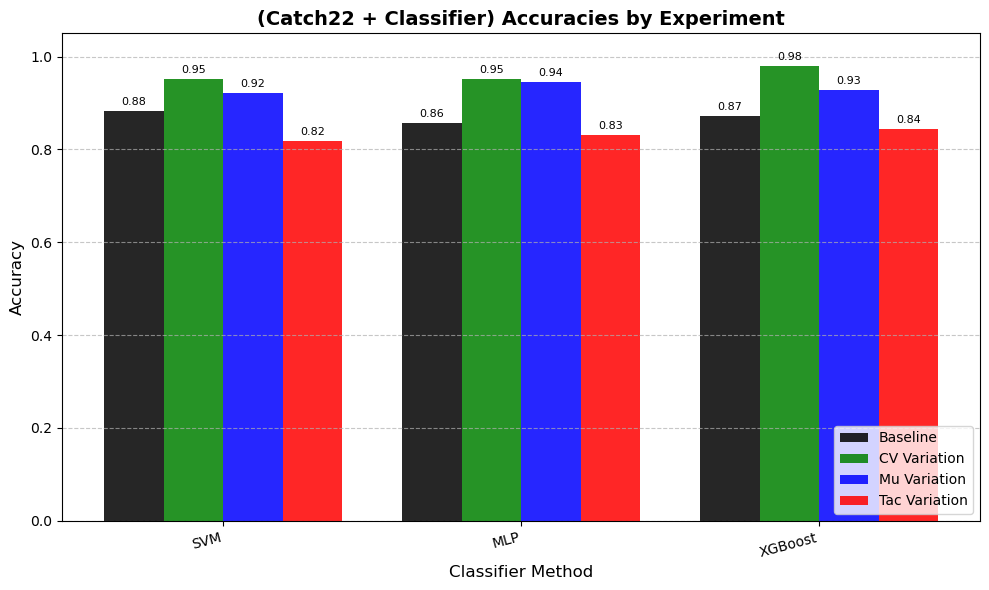

In [16]:
# plot barplot of the svm, mlp, xgb accuracies for each experiment
import matplotlib.pyplot as plt
methods = ['SVM', 'MLP', 'XGBoost']
baseline_accs = [baseline_acc_svm, baseline_acc_mlp, baseline_acc_xgb]
mu_accs = [mu_acc_svm, mu_acc_mlp, mu_acc_xgb]
cv_accs = [cv_acc_svm, cv_acc_mlp, cv_acc_xgb]
tac_accs = [tac_acc_svm, tac_acc_mlp, tac_acc_xgb]

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(methods))  # the label locations
width = 0.2  # the width of the bars
alpha = 0.85

baseline_bars = ax.bar(x - width*1.5, baseline_accs, width, alpha=alpha,
                                           label='Baseline', color=EXPERIMENTS[0]["color"])
cv_bars = ax.bar(x - width/2, cv_accs, width, alpha=alpha,       
                                 label='CV Variation', color=EXPERIMENTS[2]["color"])
mu_bars = ax.bar(x + width/2, mu_accs, width, alpha=alpha,
                                 label='Mu Variation', color=EXPERIMENTS[1]["color"])
tac_bars = ax.bar(x + width*1.5, tac_accs, width, alpha=alpha,
                                  label='Tac Variation', color=EXPERIMENTS[3]["color"]) 
for bars in [baseline_bars, cv_bars, mu_bars, tac_bars]:
    ax.bar_label(bars, fmt='%.2f', padding=3, fontsize=8)
    
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_xlabel('Classifier Method', fontsize=12)
ax.set_title('(Catch22 + Classifier) Accuracies by Experiment', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(methods, rotation=15, ha='right')

ax.legend(loc='lower right', fontsize=10)
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



=== Analyzing Physics of Baseline ===
   Extracting Catch22 features for Baseline...


/home/ianyang/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [17:26:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/tmp/ipykernel_546846/1339101168.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_imp.head(10), x='Importance', y='Feature', palette='viridis')


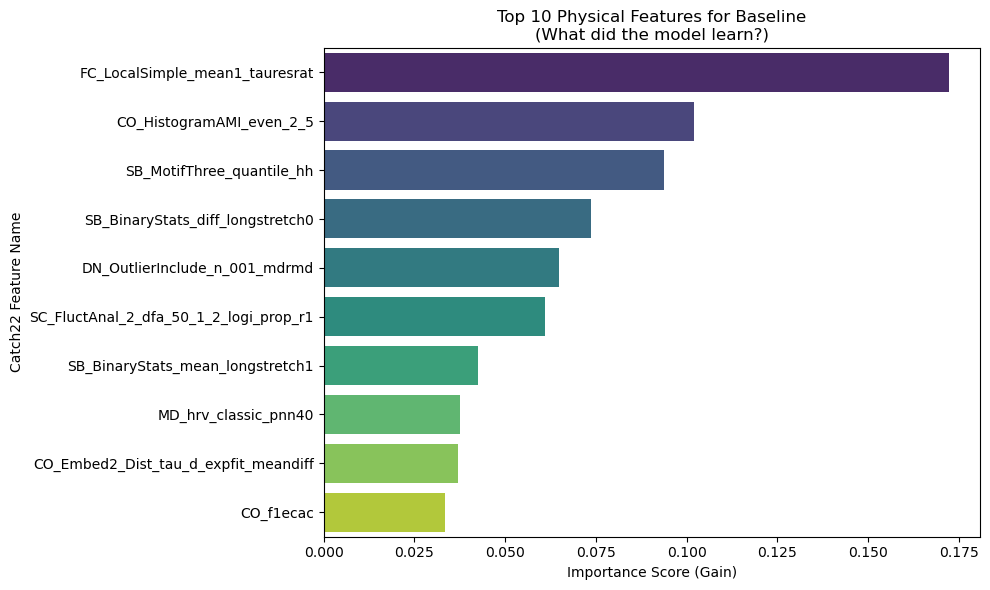

🥇 Most Critical Feature: FC_LocalSimple_mean1_tauresrat

=== Analyzing Physics of Mu Variation ===
   Extracting Catch22 features for Mu Variation...


/home/ianyang/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [17:28:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/tmp/ipykernel_546846/1339101168.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_imp.head(10), x='Importance', y='Feature', palette='viridis')


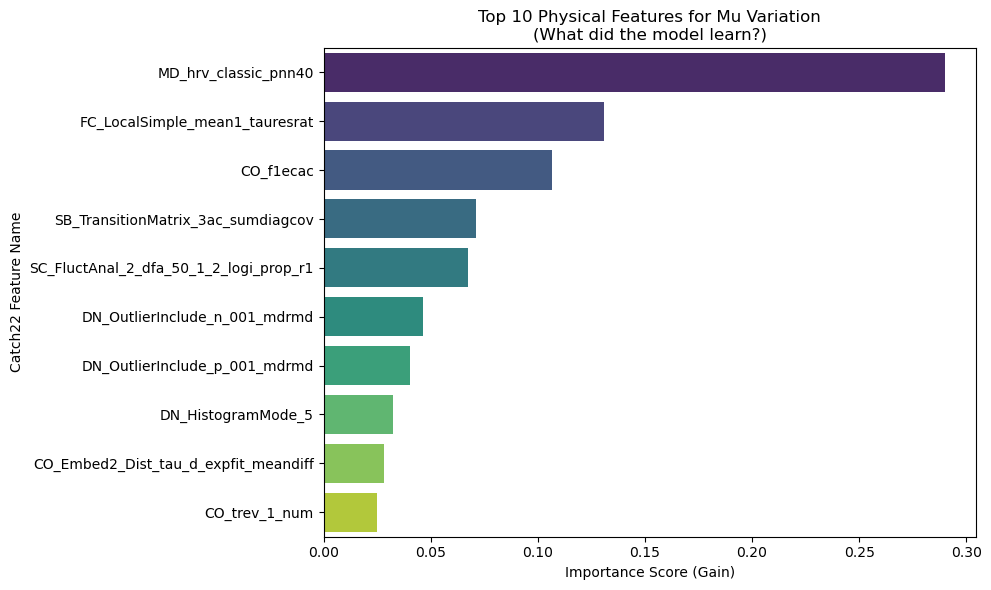

🥇 Most Critical Feature: MD_hrv_classic_pnn40

=== Analyzing Physics of Tac Variation ===
   Extracting Catch22 features for Tac Variation...


/home/ianyang/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [17:29:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/tmp/ipykernel_546846/1339101168.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_imp.head(10), x='Importance', y='Feature', palette='viridis')


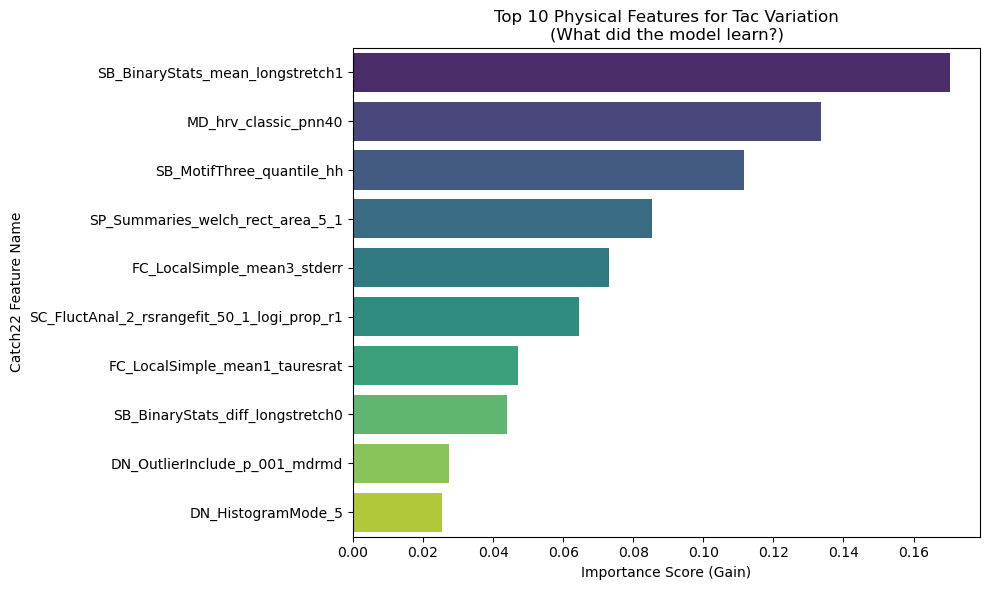

🥇 Most Critical Feature: SB_BinaryStats_mean_longstretch1

=== Analyzing Physics of CV Variation ===
   Extracting Catch22 features for CV Variation...


/home/ianyang/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [17:31:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/tmp/ipykernel_546846/1339101168.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_imp.head(10), x='Importance', y='Feature', palette='viridis')


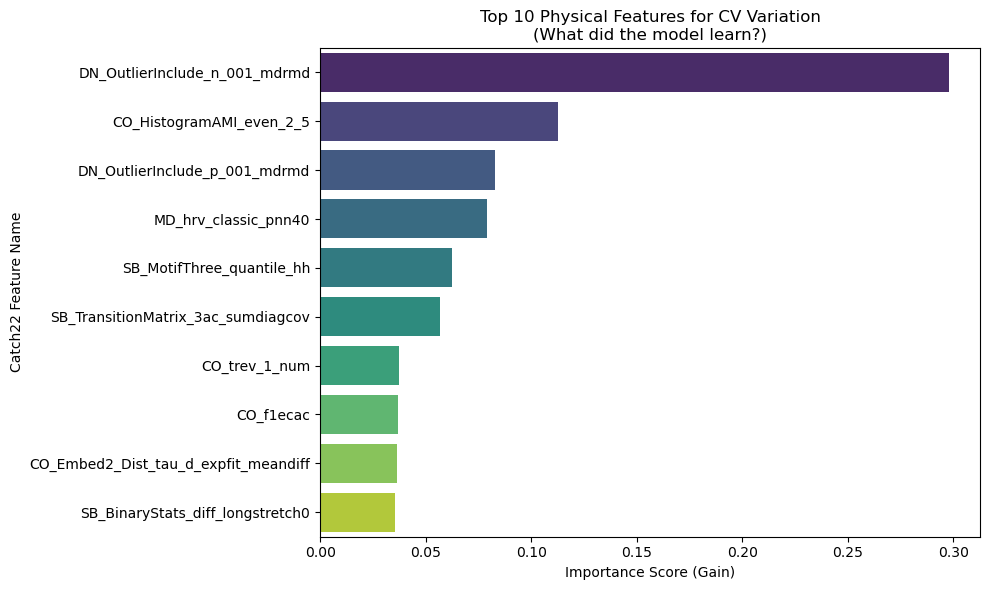

🥇 Most Critical Feature: DN_OutlierInclude_n_001_mdrmd


,Feature,Importance
14,DN_OutlierInclude_n_001_mdrmd,0.297801
4,CO_HistogramAMI_even_2_5,0.112518
13,DN_OutlierInclude_p_001_mdrmd,0.082681
6,MD_hrv_classic_pnn40,0.078839
17,SB_MotifThree_quantile_hh,0.062485
8,SB_TransitionMatrix_3ac_sumdiagcov,0.056577
5,CO_trev_1_num,0.037269
2,CO_f1ecac,0.037065
10,CO_Embed2_Dist_tau_d_expfit_meandiff,0.036387
16,SB_BinaryStats_diff_longstretch0,0.035360


In [17]:
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

def analyze_feature_importance(train_loader, exp_name):
    print(f"\n=== Analyzing Physics of {exp_name} ===")
    
    # 1. Extract Features (Catch22)
    # Re-using the function from before
    X, y = extract_catch22_from_loader(train_loader, exp_name)
    
    if len(X) == 0: return

    # 2. Train XGBoost
    model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
    model.fit(X, y)
    
    # 3. Extract Importance
    # XGBoost provides 'gain' (how much a feature improves the tree)
    importance = model.feature_importances_
    feature_names = X.columns
    
    # Create DataFrame for plotting
    df_imp = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values(by='Importance', ascending=False)
    
    # 4. Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_imp.head(10), x='Importance', y='Feature', palette='viridis')
    plt.title(f"Top 10 Physical Features for {exp_name}\n(What did the model learn?)")
    plt.xlabel("Importance Score (Gain)")
    plt.ylabel("Catch22 Feature Name")
    plt.tight_layout()
    plt.show()
    
    # Print the #1 feature and its likely meaning
    top_feat = df_imp.iloc[0]['Feature']
    print(f"🥇 Most Critical Feature: {top_feat}")
    
    return df_imp

# ==========================================
# RUN ANALYSIS
# ==========================================
analyze_feature_importance(baseline_train_loader, "Baseline")
analyze_feature_importance(mu_train_loader, "Mu Variation")
analyze_feature_importance(tac_train_loader, "Tac Variation")
analyze_feature_importance(cv_train_loader, "CV Variation")